# Inference example for trained 2D U-Net model on BraTS.
In this tutorial, we will use the Intel® Distribution of OpenVINO™ Toolkit to perform inference. We will load the OpenVINO version of the model (IR) and perform inference on a few validation samples from the Decathlon dataset.

This tutorial assumes that you have already downloaded and installed [Intel&reg; OpenVINO&trade;](https://software.intel.com/en-us/openvino-toolkit/choose-download) on your computer. These instructions assume version R5 2018.

### Inferencing with the Intel® Distribution of OpenVINO™ Toolkit

In order to use Intel® OpenVINO™, we need to do a few steps:

1. Use the OpenVINO Model Optimizer to convert the above freezed-model to the OpenVINO Intermediate Representation (IR) format
1. Load data
1. Validation
1. Inference time :)

Like we have seen in the training tutorial, we define the Sorensen Dice score coefficient, to measure of the overlap between the prediction and ground truth masks:

In [1]:
import numpy as np

def calc_dice(target, prediction, smooth=0.0001):
    """
    Sorensen Dice coefficient
    """
    prediction = np.round(prediction)

    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

def calc_soft_dice(target, prediction, smooth=0.0001):
    """
    Sorensen (Soft) Dice coefficient - Don't round predictions
    """
    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

### Step 1: Convert the Tensorflow* saved model to the Intermediate Representation (IR) with Intel® OpenVINO™

In this step, we will use the Intel® OpenVINO™'s `model optimizer` to convert the frozen TensorFlow* model to Intel® OpenVINO™ IR format. Once you have a frozen model, you can use the Intel® OpenVINO™ `model optimizer` to create the Intel® OpenVINO™ version.

Let's first set up a few environment variables for the bash code snippet to work. The code below will create a **FP32** precision model. 

In order to call `mo_ty.py` directly from this script, it is advisable to source the OpenVINO vars in your `.bashrc` script:
`source /opt/intel/openvino/bin/setupvars.sh`

In [2]:
saved_model_dir = "./output/2d_unet_decathlon"

batch_size = 1

import os

# Create output directory for images
png_directory = "inference_examples"
if not os.path.exists(png_directory):
    os.makedirs(png_directory)

if not os.path.exists(saved_model_dir):
    print('File {} doesn\'t exist. Please make sure you have a trained TF model'.format(saved_model_dir))

precision="FP32"
openvino_model_dir = os.path.join("output", precision)
openvino_model_name = "2d_unet_decathlon"

!mo_tf.py \
      --saved_model_dir $saved_model_dir \
      --batch $batch_size \
      --data_type $precision \
      --output_dir $openvino_model_dir \
      --model_name $openvino_model_name

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/home/tony/unet/2D/output/FP32
	- IR output name: 	2d_unet_decathlon
	- Log level: 	ERROR
	- Batch: 	1
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- Update the configuration file with input/output node names: 	None
	- Use configuration file used to generate the model with Object Dete

If you would like to infer on a Neural Compute Stick, you will need to output a **FP16** precision model. To do this, you simply need to change the `--data_type` from FP32 to FP16:

```
!mo_tf.py \
      --saved_model_dir $saved_model_dir \
      --batch $batch_size \
      --data_type FP16  \
      --output_dir openvino_model_dir/FP16  \
      --model_name 2d_unet_decathlon
```

### Step 2: Load Data

In [3]:
data_path = "../data/decathlon/Task01_BrainTumour/2D_model/"

crop_dim=128  # -1 = Original resolution (240)
batch_size = 128
seed=816  # Change this to see different examples in the test dataset

In [4]:
from dataloader import DatasetGenerator

ds_testing = DatasetGenerator(os.path.join(data_path, "testing/*.npz"), 
                              crop_dim=crop_dim, 
                              batch_size=batch_size, 
                              augment=False, 
                              seed=seed)

### Step 3: Validation

### Inferencing with Intel® OpenVINO™

In [5]:
from openvino.inference_engine import IECore

import numpy as np

The `print_stats` prints layer by layer inference times. This is good for profiling which ops are most costly in your model.

In [6]:
path_to_xml_file = "{}.xml".format(os.path.join(openvino_model_dir, openvino_model_name))
path_to_bin_file = "{}.bin".format(os.path.join(openvino_model_dir, openvino_model_name))
print("OpenVINO IR: {}, {}".format(path_to_xml_file, path_to_bin_file))

ie = IECore()
net = ie.read_network(model=path_to_xml_file, weights=path_to_bin_file)

input_layer_name = next(iter(net.input_info))
output_layer_name = next(iter(net.outputs))
print("Input layer name = {}\nOutput layer name = {}".format(input_layer_name, output_layer_name))

exec_net = ie.load_network(network=net, device_name="CPU", num_requests=1)

/home/tony/anaconda3/envs/decathlon/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OpenVINO IR: output/FP32/2d_unet_decathlon.xml, output/FP32/2d_unet_decathlon.bin
Input layer name = mrimages
Output layer name = StatefulPartitionedCall/2DUNet_Brats_Decathlon/PredictionMask/Sigmoid


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import time 

def plot_results(ds, idx):
    
    dt = ds.get_dataset().take(1).as_numpy_iterator()  # Get some examples (use different seed for different samples)

    plt.figure(figsize=(10,10))

    for img, msk in dt:

        plt.subplot(1, 3, 1)
        plt.imshow(img[idx, :, :, 0], cmap="bone", origin="lower")
        plt.title("MRI {}".format(idx), fontsize=20)

        plt.subplot(1, 3, 2)
        plt.imshow(msk[idx, :, :], cmap="bone", origin="lower")
        plt.title("Ground truth", fontsize=20)

        plt.subplot(1, 3, 3)

        # Predict using the OpenVINO model
        # NOTE: OpenVINO expects channels first for input and output
        # So we transpose the input and output
        start_time = time.time()
        res = exec_net.infer({input_layer_name: np.transpose(img[[idx]], [0,3,1,2])})
        prediction = np.transpose(res[output_layer_name], [0,2,3,1])    
        print("Elapsed time = {:.4f} msecs".format(1000.0*(time.time()-start_time)))
        
        plt.imshow(prediction[0,:,:,0], cmap="bone", origin="lower")
        plt.title("Prediction\nDice = {:.4f}".format(calc_dice(msk[idx, :, :], prediction)), fontsize=20)
        
        plt.savefig(os.path.join(png_directory, "prediction_openvino_{}.png".format(idx)))


Plot the predictions with Matplotlib and save to PNG files

/home/tony/anaconda3/envs/decathlon/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Elapsed time = 17.5011 msecs


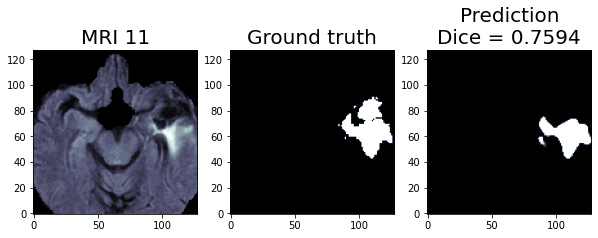

In [8]:
plot_results(ds_testing, 11)

Elapsed time = 11.2052 msecs


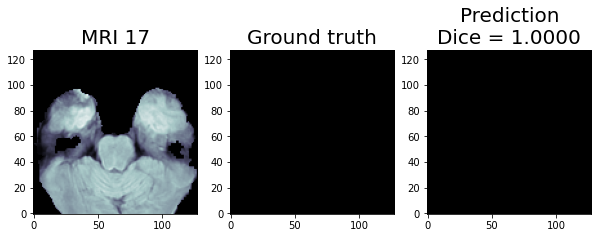

In [9]:
plot_results(ds_testing, 17)

Elapsed time = 10.4194 msecs


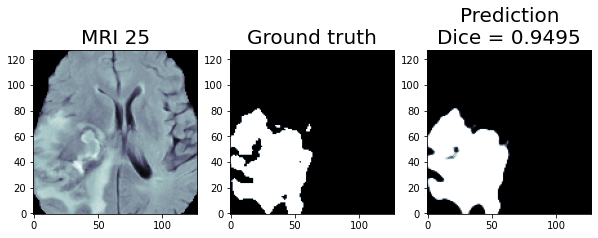

In [16]:
plot_results(ds_testing, 25)

Elapsed time = 7.6749 msecs


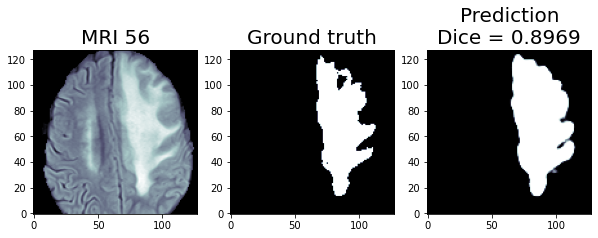

In [11]:
plot_results(ds_testing, 56)

Elapsed time = 32.3617 msecs


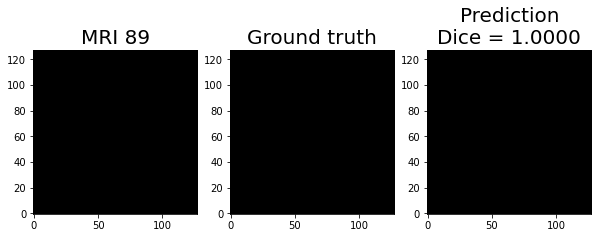

In [12]:
plot_results(ds_testing, 89)

Elapsed time = 8.8396 msecs


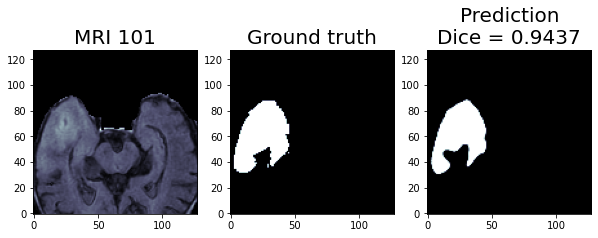

In [13]:
plot_results(ds_testing, 101)

Elapsed time = 23.7222 msecs


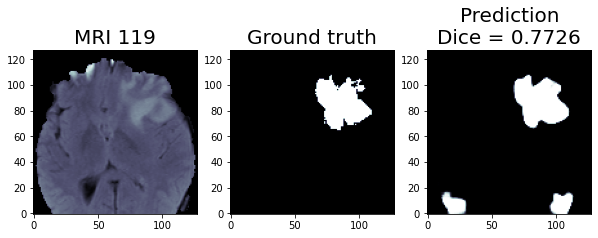

In [14]:
plot_results(ds_testing, 119)

*Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. SPDX-License-Identifier: EPL-2.0*

*Copyright (c) 2019-2020 Intel Corporation*